# Package Download

In [1]:
list.of.packages <- c("rTensor", "ggplot2", "reshape2", "RColorBrewer")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)){
    install.packages(new.packages,
        repos="https://cloud.r-project.org/", type="source")
}

# Package Loading

In [2]:
library("rTensor")
library("ggplot2")
library("reshape2")
library("RColorBrewer")

# Setting

In [3]:
options(repr.plot.width=6, repr.plot.height=12)

# Function Definition

In [4]:
load_serology <- function(){
	# Download from Zenodo Server
	td <- tempdir()
    tempfile <- paste0(td, "/meyer-lab-systemsSerology-fd9ef61.zip")
    download.file("https://zenodo.org/record/5184449/files/meyer-lab/systemsSerology-v1.0.zip?download=1", tempfile)
    # Preprocessing
    unzip(tempfile, exdir=td)
    csvfile <- paste0(td, "/meyer-lab-systemsSerology-fd9ef61/syserol/data/ZoharCovData.csv")
    data <- read.csv(csvfile, row.names=1, header=TRUE)
    serology <- t(t(as.matrix(data[, 23:140])) - unlist(data[443, 23:140]))
    serology <- serology[1:438, ]
    # Data frame -> Array
    receptor <- c("IgG1", "IgG2", "IgG3", "IgA1", "IgA2", "IgM", "FcRalpha", "FcR2A", "FcR2B", "FcR3A", "FcR3B")
    antigen <- c("S", "RBD", "N", "S1", "S2", "S1.Trimer")
    arr <- array(0, dim=c(11, 6, 438))
    dimnames(arr) <- list(
        receptor = receptor,
        antigen = antigen,
        samples = rownames(serology))
    for(i in receptor){
        for(j in antigen){
            arr[i, j, ] <- serology[, paste0(i, "_", j)]
        }
    }
    # Log Transformation
    arr[which(arr < 0)] <- 10
    arr <- log10(arr)
    # Centering
    for(k in seq_len(dim(arr)[3])){
        arr[,,k] <- arr[,,k] - mean(arr[,,k])
    }
    # Array -> Tensor
    covid19 <- as.tensor(arr)
    # Group Label
    group <- cbind(rownames(data)[1:438], data$group[1:438])
    colnames(group) <- c("Sample", "Group")
    # Output
    list(covid19=covid19, group=group)
}

# Serology Data

In [5]:
serology_data <- load_serology()
covid19 <- serology_data$covid19
group <- serology_data$group

# Tucker Decomposition

In [6]:
J = 2
res_tucker <- hosvd(covid19, ranks=rep(J, length=3))

  |======================================================================| 100%


# Receptor Patterns

## Preprocessing

In [7]:
pattern_r <- res_tucker$U[[1]]
rownames(pattern_r) <- dimnames(covid19@data)$receptor
colnames(pattern_r) <- paste("Component", seq(J))
df_r <- melt(pattern_r)
colnames(df_r) <- c("Receptor", "Component", "Value")
df_r$Receptor <- factor(df_r$Receptor, level=rev(unique(df_r$Receptor)))

## Plot Receptor Patterns

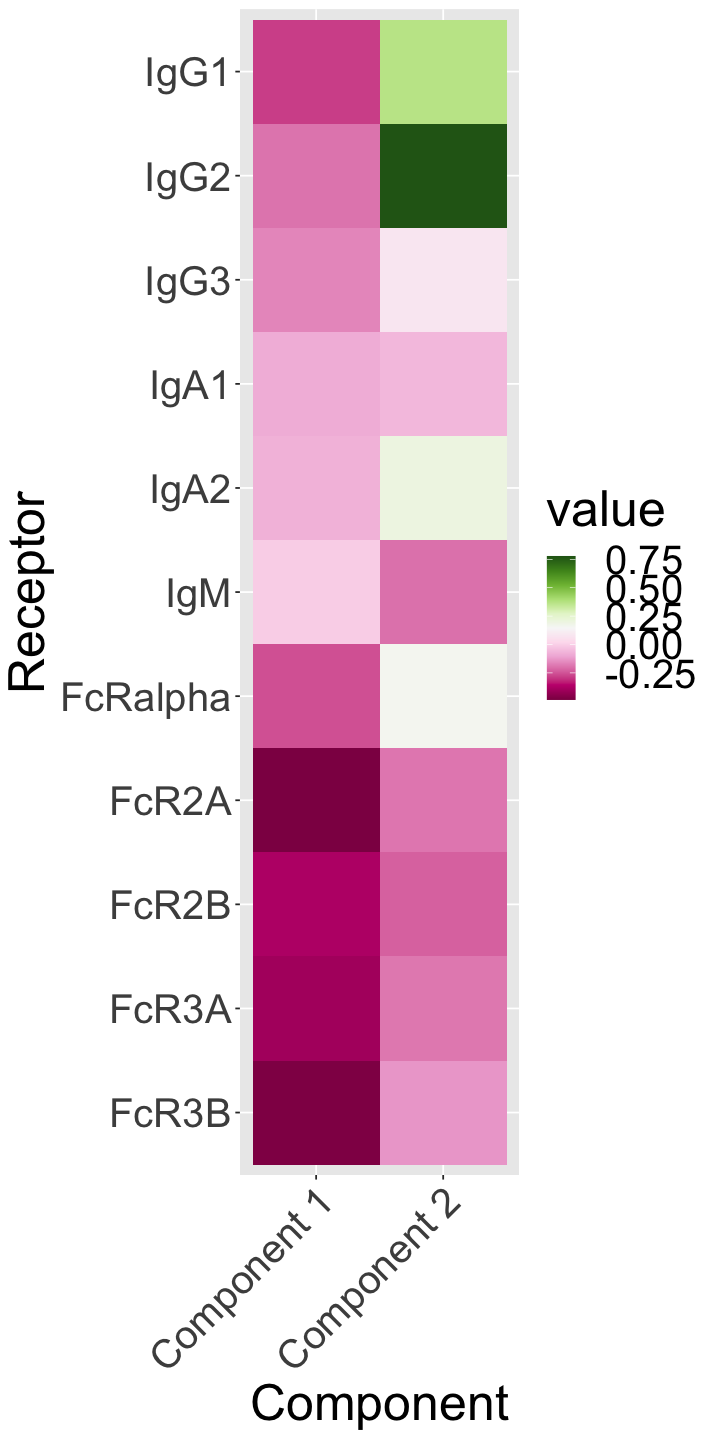

In [8]:
g_r <- ggplot(df_r, aes(x=Component, y=Receptor, fill = Value))
g_r <- g_r + geom_tile()
g_r <- g_r +  scale_fill_gradientn("value", colours = brewer.pal(11, "PiYG"))
g_r <- g_r + theme(axis.text.x = element_text(angle = 45, hjust = 1))
g_r <- g_r + theme(text = element_text(size=30))
g_r

# Antigen Patterns

## Preprocessing

In [9]:
pattern_a <- res_tucker$U[[2]]
rownames(pattern_a) <- dimnames(covid19@data)$antigen
colnames(pattern_a) <- paste("Component", seq(J))
df_a <- melt(pattern_a)
colnames(df_a) <- c("Antigen", "Component", "Value")
df_a$Antigen <- factor(df_a$Antigen, level=rev(unique(df_a$Antigen)))

## Plot Antigen Patterns

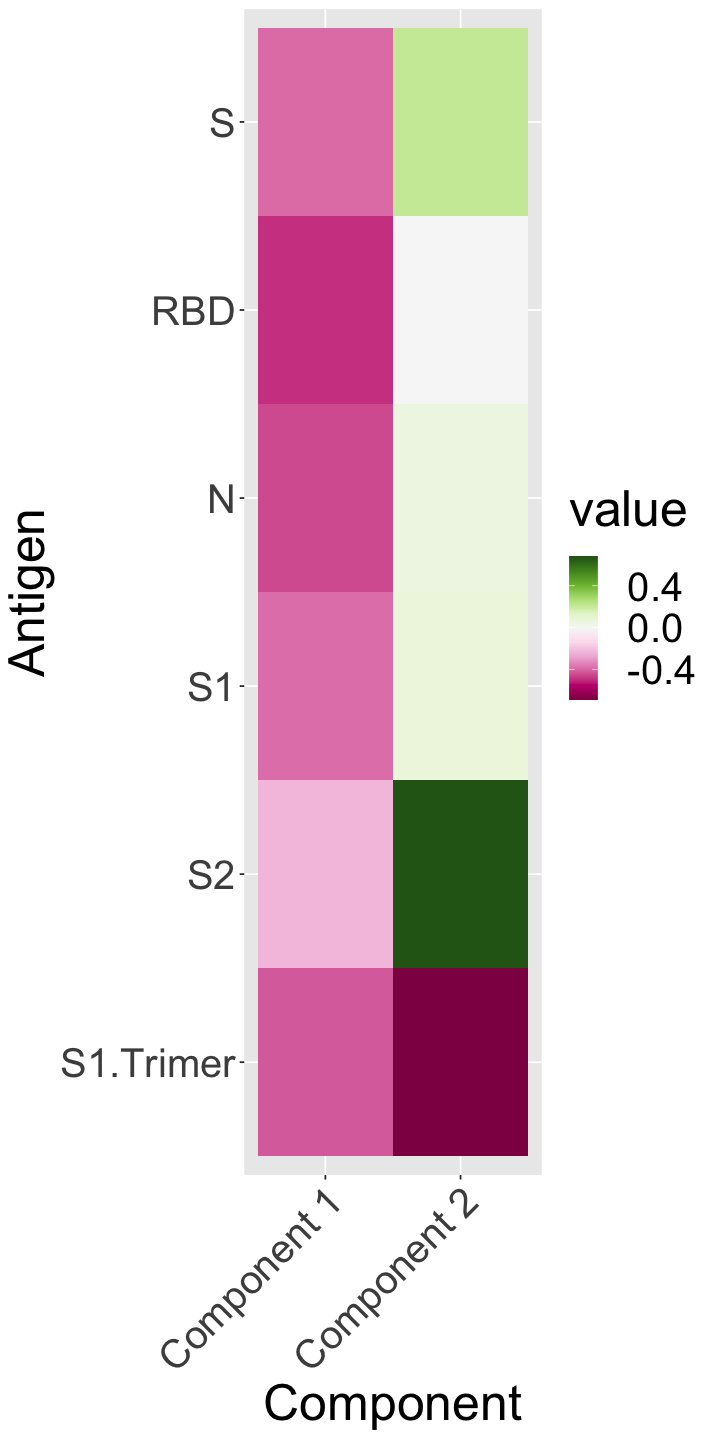

In [10]:
g_a <- ggplot(df_a, aes(x=Component, y=Antigen, fill = Value))
g_a <- g_a + geom_tile()
g_a <- g_a +  scale_fill_gradientn("value", colours = brewer.pal(11, "PiYG"))
g_a <- g_a + theme(axis.text.x = element_text(angle = 45, hjust = 1))
g_a <- g_a + theme(text = element_text(size=30))
g_a

# Sample Patterns

## Preprocessing

In [11]:
pattern_s <- res_tucker$U[[3]]
rownames(pattern_s) <- dimnames(covid19@data)$samples
colnames(pattern_s) <- paste("Component", seq(J))
df_s <- melt(pattern_s)
df_s <- merge(df_s, group, by.x="Var1", by.y="Sample")
colnames(df_s) <- c("Sample", "Component", "Value", "Group")
df_s$Sample <- factor(df_s$Sample, level=rev(unique(df_s$Sample)))
df_s$Group <- factor(df_s$Group, level=c("Negative", "Mild", "Moderate", "Severe", "Deceased"))

## Plot Sample Patterns

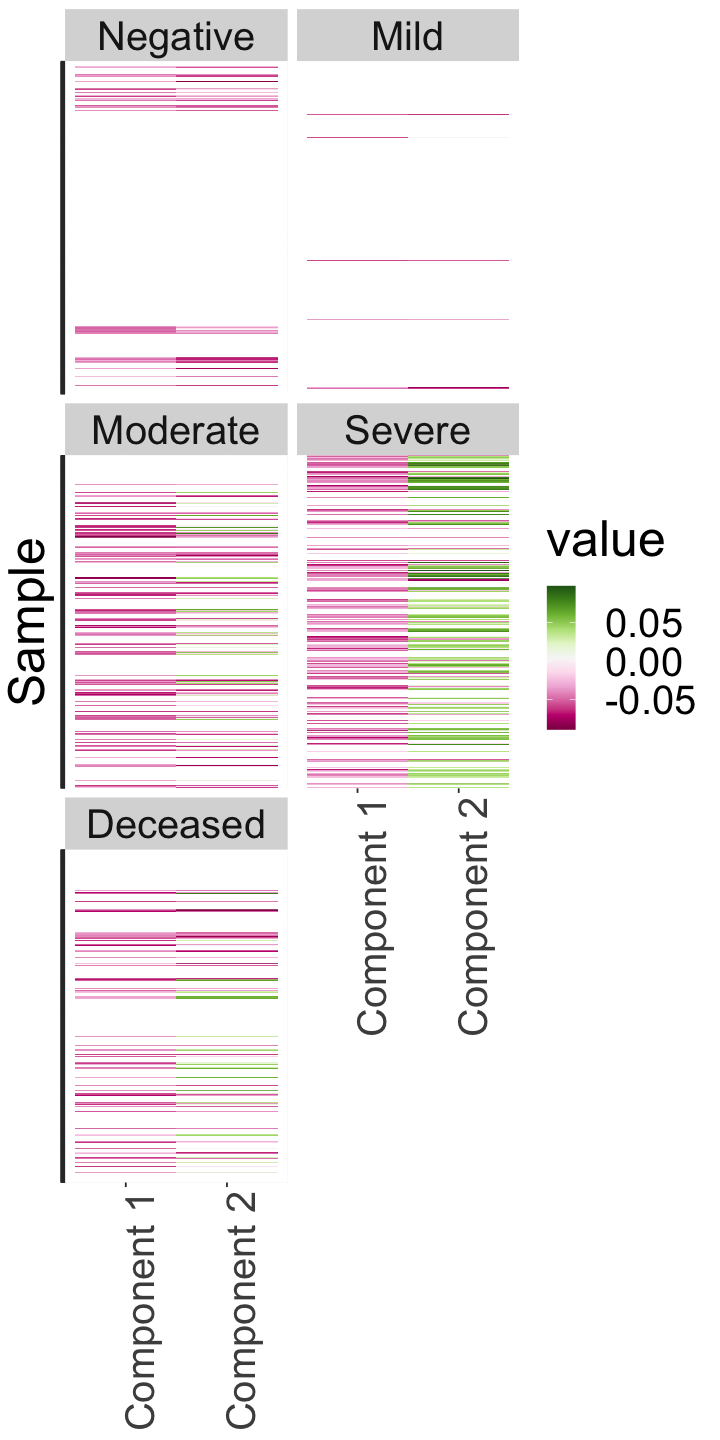

In [12]:
g_s <- ggplot(df_s, aes(x=Component, y=Sample, fill = Value))
g_s <- g_s + geom_tile()
g_s <- g_s + facet_wrap(~Group, ncol=2)
g_s <- g_s +  scale_fill_gradientn("value", colours = brewer.pal(11, "PiYG"))
g_s <- g_s + theme(axis.text.x = element_text(angle = 90, hjust = 1))
g_s <- g_s + theme(axis.title.x = element_blank())
g_s <- g_s + theme(axis.text.y = element_blank())
g_s <- g_s + theme(text = element_text(size=30))
g_s

# Session Information

In [13]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS/LAPACK: /Users/tsuyusakikouki/opt/anaconda3/envs/r-4.1/lib/libopenblasp-r0.3.15.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] RColorBrewer_1.1-3 reshape2_1.4.4     ggplot2_3.3.5      rTensor_1.4.8     

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.8.3     plyr_1.8.7       pillar_1.7.0     compiler_4.1.0  
 [5] base64enc_0.1-3  tools_4.1.0      digest_0.6.29    uuid_1.0-4      
 [9] jsonlite_1.8.0   evaluate_0.15    lifecycle_1.0.1  tibble_3.1.6    
[13] gtable_0.3.0     pkgconfig_2.0.3  rlang_1.0.2      DBI_1.1.3       
[17] IRdisplay_1.1    cli_3.3.0        IRkernel_1.3     fastmap_1.1.0   
[21] stringr_1.4.0    withr_2.5.0      repr_1.1.4       dplyr_1.0.8     
[25] generics_0.1.2   vctrs_0.4.0      grid_4.1.0      